In [1]:
import torch
import wandb
from hydra import compose, initialize

from src.evaluation.visual.visualize import visualize_dvinp_both
from src.utils.load_dvinp import load_dvinp
from src.utils.helper import download_run

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
project = "cluster-dvinp-score2" # "cluster-dvinp-noscore" # 
name =  "16-1-bca-free-dis-True-True-context-1.0-0" # "16-1-bca-free-dis-True-False-context-1.0-0" # "16-1-bca-free-dis-True-False-forwardandcontext-1.0-0"
dir = download_run(project, name)

# dir = f"models/dvinp"

CommError: failed to find artifact collection 16-1-bca-free-dis-True-True-context-1.0-0_model.pth (Error 404: Not Found)

In [ ]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, _ = load_dvinp(
        cfg=cfg, 
        device=device, 
        dir=dir, 
        load_decoder_only=False, 
        train_decoder=True
    ) 


Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 288035.36it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


loaded model from models/cluster-dvinp-noscore/16-1-bca-free-dis-True-False-context-1.0-0/model.pth
loaded optim from models/cluster-dvinp-noscore/16-1-bca-free-dis-True-False-context-1.0-0/optim.pth


In [ ]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="test", name="".join([f"({v})" for v in cfg.model.values()]))

In [ ]:
train = False

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 10
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=cfg.training.alpha,
        validate=False
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

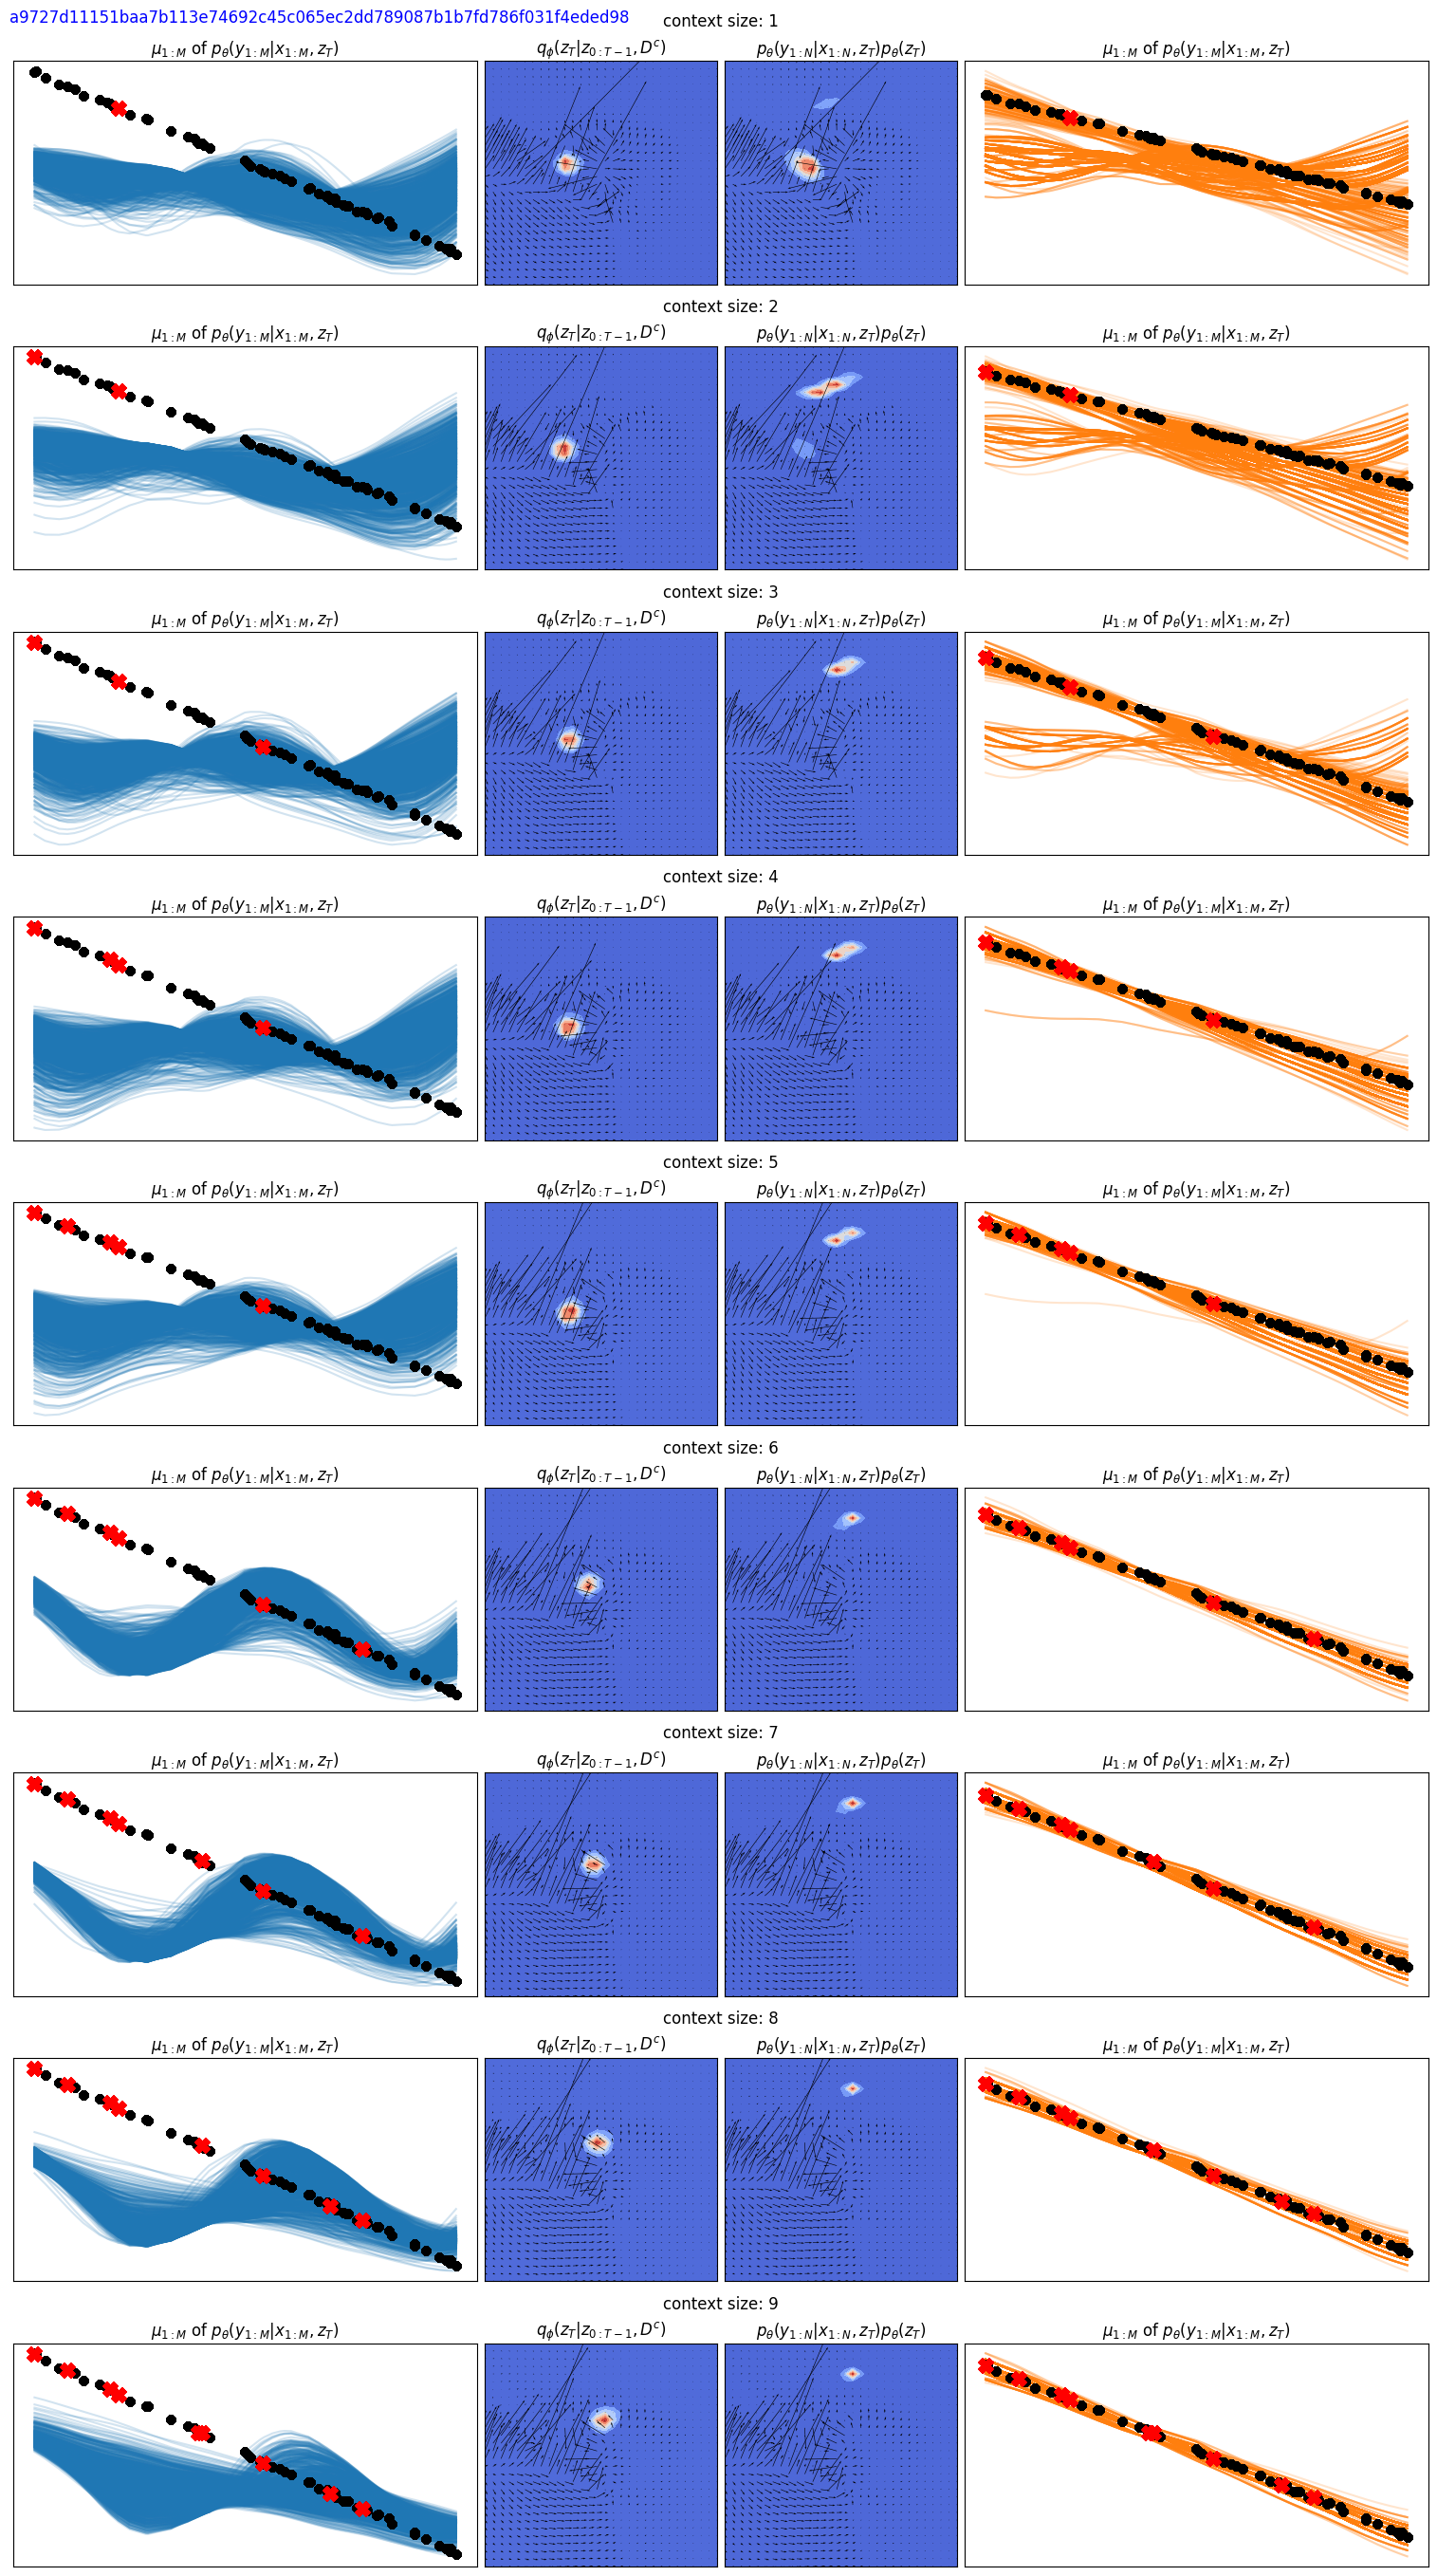

In [12]:
max_context_size = 9
num_samples = 900 # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)